In [216]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [217]:
df_high = pd.read_csv('high_popularity_spotify_data.csv')
df_low = pd.read_csv('low_popularity_spotify_data.csv')

In [218]:
df= pd.concat([df_low,df_high])
df.drop_duplicates(subset=['id'],keep='first',inplace=True)
df[df['track_artist']=='Metallica']['id']

77      54bm2e3tk8cliUz3VSdCPZ
578     2MuWTIM3b0YEAskbeeFE1i
583     5IX4TbIR5mMHGE4wiWwKW0
587     5sICkBXVmaCQk5aISGR3x1
1111    28WmNsclKsrVmdv3tDmoYU
Name: id, dtype: object

In [219]:
#convert artists to artist this does mean songs occur more than once remember this in the machine learning phase
df['artist_list'] = df['track_artist'].str.split(',')
df = df.explode('artist_list')
df['artist_list'] = df['artist_list'].str.strip()
df = df.drop(columns='track_artist').rename(columns={'artist_list':'track_artist'})

In [220]:
df.isnull().sum()

time_signature              1
track_popularity            0
speechiness                 1
danceability                1
playlist_name               0
duration_ms                 1
energy                      1
playlist_genre              0
playlist_subgenre           0
track_href                  1
track_name                  0
mode                        1
uri                         1
type                        1
track_album_release_date    0
analysis_url                1
id                          1
instrumentalness            1
track_album_id              0
playlist_id                 0
track_id                    0
valence                     1
key                         1
tempo                       1
loudness                    1
acousticness                1
liveness                    1
track_album_name            1
track_artist                0
dtype: int64

In [221]:
#going to drop the null values since theres not enough of them to affect the model
df.dropna(inplace=True)

In [222]:
#we cant remove outliers as this removes possible songs they have listened to but we need some sort of categorical encoding and need to decide important columns
df.dtypes

time_signature              float64
track_popularity              int64
speechiness                 float64
danceability                float64
playlist_name                object
duration_ms                 float64
energy                      float64
playlist_genre               object
playlist_subgenre            object
track_href                   object
track_name                   object
mode                        float64
uri                          object
type                         object
track_album_release_date     object
analysis_url                 object
id                           object
instrumentalness            float64
track_album_id               object
playlist_id                  object
track_id                     object
valence                     float64
key                         float64
tempo                       float64
loudness                    float64
acousticness                float64
liveness                    float64
track_album_name            

In [223]:
#keeping the id so that I can regoginise the data
columns_dropped = ['track_href','playlist_name', 'uri', 'analysis_url', 'playlist_id', 'type', 'playlist_subgenre']

In [224]:
df.drop(columns = columns_dropped, axis=1, inplace=True)

In [225]:
df['track_album_release_date'] = pd.to_datetime(df['track_album_release_date'], errors='raise', format='mixed')
df['track_album_release_date']= (df['track_album_release_date'] - df['track_album_release_date'].min()).dt.days

In [226]:
from sklearn.preprocessing import OneHotEncoder 

In [227]:
genre_encoder = OneHotEncoder(sparse_output=False)
genre_encoded = genre_encoder.fit_transform(df[['playlist_genre']])
genre_df=pd.DataFrame(genre_encoded, columns=genre_encoder.get_feature_names_out(['playlist_genre']),index=df.index)
df=pd.concat([df,genre_df],axis=1)

In [228]:
#cluster artists 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [229]:
artists_features = df.groupby('track_artist')[['track_popularity', 'track_album_release_date','playlist_genre_afrobeats', 'playlist_genre_ambient',
       'playlist_genre_arabic', 'playlist_genre_blues',
       'playlist_genre_brazilian', 'playlist_genre_cantopop',
       'playlist_genre_classical', 'playlist_genre_country',
       'playlist_genre_disco', 'playlist_genre_electronic',
       'playlist_genre_folk', 'playlist_genre_funk', 'playlist_genre_gaming',
       'playlist_genre_gospel', 'playlist_genre_hip-hop',
       'playlist_genre_indian', 'playlist_genre_indie', 'playlist_genre_j-pop',
       'playlist_genre_jazz', 'playlist_genre_k-pop', 'playlist_genre_korean',
       'playlist_genre_latin', 'playlist_genre_lofi',
       'playlist_genre_mandopop', 'playlist_genre_metal', 'playlist_genre_pop',
       'playlist_genre_punk', 'playlist_genre_r&b', 'playlist_genre_reggae',
       'playlist_genre_rock', 'playlist_genre_soca', 'playlist_genre_soul',
       'playlist_genre_turkish', 'playlist_genre_wellness',
       'playlist_genre_world']].mean()

In [ ]:
scaler = StandardScaler()
X_scaled=scaler.fit_transform(artists_features)
df.isnull().sum().sort_values()

time_signature               0
track_popularity             0
speechiness                  0
danceability                 0
duration_ms                  0
energy                       0
playlist_genre               0
track_name                   0
mode                         0
track_album_release_date     0
id                           0
instrumentalness             0
track_album_id               0
track_id                     0
valence                      0
key                          0
tempo                        0
loudness                     0
acousticness                 0
liveness                     0
track_album_name             0
track_artist                 0
playlist_genre_afrobeats     0
playlist_genre_ambient       0
playlist_genre_arabic        0
playlist_genre_blues         0
playlist_genre_brazilian     0
playlist_genre_cantopop      0
playlist_genre_classical     0
playlist_genre_country       0
playlist_genre_disco         0
playlist_genre_electronic    0
playlist

In [231]:
kmeans = KMeans(n_clusters=36, random_state=44)
artists_features['cluster'] = kmeans.fit_predict(X_scaled)
labels= kmeans.fit_predict(X_scaled)

In [232]:
score = silhouette_score(X_scaled, kmeans.labels_)
print("Silhouette Score:", score)

Silhouette Score: 0.6511586241646558


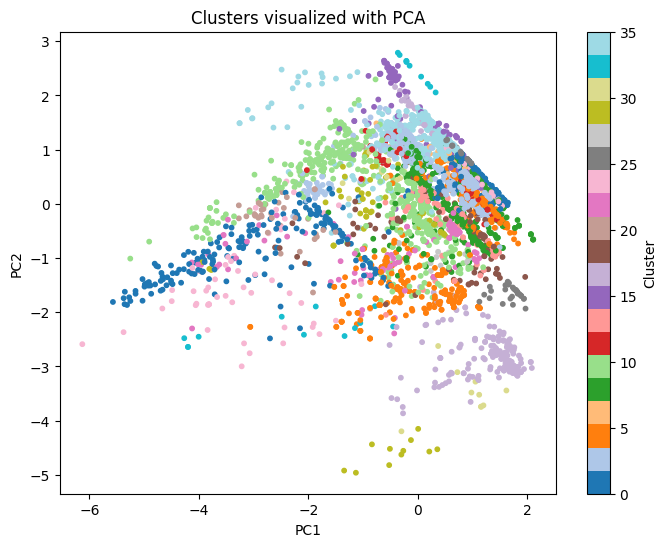

In [233]:
from sklearn.decomposition import PCA

# Reduce to 2 principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot clusters
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab20', s=10)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters visualized with PCA')
plt.colorbar(label='Cluster')
plt.show()

In [234]:
artist_encoder=OneHotEncoder(sparse_output=False)
cluster_encoded=artist_encoder.fit_transform(artists_features[['cluster']])
cluster_df=pd.DataFrame(cluster_encoded,
                        columns=artist_encoder.get_feature_names_out(['cluster']),
                        index=artists_features.index)
df=df.merge(cluster_df,
            left_on='track_artist',
            right_index=True,
            how='left')

In [235]:
print(df.columns.tolist())
df.drop(columns=['playlist_genre','track_album_id','track_album_id','track_album_name','track_id'],axis=1,inplace=True)

['time_signature', 'track_popularity', 'speechiness', 'danceability', 'duration_ms', 'energy', 'playlist_genre', 'track_name', 'mode', 'track_album_release_date', 'id', 'instrumentalness', 'track_album_id', 'track_id', 'valence', 'key', 'tempo', 'loudness', 'acousticness', 'liveness', 'track_album_name', 'track_artist', 'playlist_genre_afrobeats', 'playlist_genre_ambient', 'playlist_genre_arabic', 'playlist_genre_blues', 'playlist_genre_brazilian', 'playlist_genre_cantopop', 'playlist_genre_classical', 'playlist_genre_country', 'playlist_genre_disco', 'playlist_genre_electronic', 'playlist_genre_folk', 'playlist_genre_funk', 'playlist_genre_gaming', 'playlist_genre_gospel', 'playlist_genre_hip-hop', 'playlist_genre_indian', 'playlist_genre_indie', 'playlist_genre_j-pop', 'playlist_genre_jazz', 'playlist_genre_k-pop', 'playlist_genre_korean', 'playlist_genre_latin', 'playlist_genre_lofi', 'playlist_genre_mandopop', 'playlist_genre_metal', 'playlist_genre_pop', 'playlist_genre_punk', 'pl

In [236]:
df.to_csv('cleaned_data.csv')

In [237]:
df[df['track_artist']=='Metallica']

,time_signature,track_popularity,speechiness,danceability,duration_ms,energy,track_name,mode,track_album_release_date,id,...,cluster_26,cluster_27,cluster_28,cluster_29,cluster_30,cluster_31,cluster_32,cluster_33,cluster_34,cluster_35
77,4.0,70,0.0350,0.539,515387.0,0.828,Master of Puppets (Remastered),0.0,11749,54bm2e3tk8cliUz3VSdCPZ,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
578,4.0,75,0.0353,0.543,515387.0,0.836,Master Of Puppets,0.0,11749,2MuWTIM3b0YEAskbeeFE1i,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
583,3.0,72,0.0617,0.437,447440.0,0.695,One,1.0,12655,5IX4TbIR5mMHGE4wiWwKW0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
587,4.0,79,0.0298,0.577,331267.0,0.828,Enter Sandman,0.0,13737,5sICkBXVmaCQk5aISGR3x1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1111,4.0,68,0.2820,0.445,414720.0,0.964,Seek & Destroy - Remastered,1.0,10796,28WmNsclKsrVmdv3tDmoYU,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
